In [1]:
import math
from typing import List

import matplotlib.pyplot as plt
from migen import Signal, If, Memory

from deltalanguage.data_types import (DInt, DUInt, DOptional, DSize,
                                      make_forked_return)
from deltalanguage.runtime import DeltaPySimulator, DeltaRuntimeExit

from deltalanguage.runtime._queues import Flusher
from deltalanguage.wiring import (DeltaGraph,
                                  Interactive,
                                  MigenNodeTemplate,
                                  PyInteractiveNode,
                                  placeholder_node_factory)

## Sine Wave Generator

The Sine wave generator is implemented through Direct Digital Synthesis, as  
depicted below: a Numeric-Controlled-Oscillator (NCO) drives a Look-Up-Table  
storing precomputed sine values. 

<div>
<img src="ddssinewave.png" width="600"/>
</div>

Parameters:

- LUT_ADDR_SIZE : LUT address width 
- LUT_WIDTH     : Bitwidth for each Sine-Wave LUT entry
- NCO_SIZE      : NCO Register Bitwidth.
- CLOCK_FREQ    : Clock Frequency (Hz). Must match the DAC sampling frequency

Input ports:

- rst_nco  : Reset the NCO value, and the output phase  
- nco_en   : enables the sine-wave generation, at the specified output frequency  
- nco_inc  : NCO increment: specifies the output frequency f_out:  
             nco_inc = (f_out/CLOCK_FREQ)*(2**NCO_SIZE)

Output port:

- cw       : Continuous Wave output (Sine)

In [2]:
LUT_ADDR_SIZE = 10
LUT_WIDTH = 16
NCO_SIZE = 32
CLOCK_FREQ = 200e6


def gen_sine_lut(lut_size: int, lut_width: int) -> List[int]:
    """Generate the NCO sine-wave Look-Up-Table."""
    norm = 2**(lut_width-1) - 1

    lut = []
    for x in range(lut_size):
        lut.append(int(norm * math.sin(2 * math.pi * x / lut_size)))

    return lut


class DDSSineWave(MigenNodeTemplate):
    """A node that implements a simple sine wave generator through
    Direct Digital Synthesis (DDS), meant to drive a DAC with a suitable
    reconstruction filter.

    Inputs:
    - rst_nco  : Reset the NCO value, and the output phase
    - nco_en   : enables the sine-wave generation, at the specified output frequency
    - nco_inc  : NCO increment: specifies the output frequency f_out:
                   nco_inc = (f_out/CLOCK_FREQ)*(2**NCO_SIZE)

    Outputs:
    - cw       : Continuous Wave (Sine)   
    """

    def migen_body(self, template):
        # Port Map
        rst_nco = template.add_pa_in_port('rst_nco', DOptional(DInt(DSize(1))))
        nco_en = template.add_pa_in_port('nco_en',  DOptional(DInt(DSize(1))))
        nco_inc = template.add_pa_in_port(
            'nco_inc', DOptional(DUInt(DSize(NCO_SIZE)))
        )
        cw = template.add_pa_out_port('cw',     DInt(DSize(LUT_WIDTH)))

        # Signal declarations
        running = Signal()
        running_d = Signal()
        nco = Signal(NCO_SIZE)
        nco_inc_i = Signal(NCO_SIZE)

        # Sine-Wave LUT:
        LUT_SIZE = 2 ** LUT_ADDR_SIZE
        self.specials.sine_lut = Memory(
            LUT_WIDTH, LUT_SIZE, init=gen_sine_lut(LUT_SIZE, LUT_WIDTH))
        lut_port = self.sine_lut.get_port(write_capable=False)
        self.specials += lut_port

        self.comb += [
            rst_nco.ready.eq(1),
            nco_en.ready.eq(1),
            nco_inc.ready.eq(1),
            lut_port.adr.eq(nco[NCO_SIZE-LUT_ADDR_SIZE:])
        ]

        self.sync += [
            # Latch Control registers
            If(nco_en.valid == 1,
                running.eq(nco_en.data)
               ),
            If(nco_inc.valid,
                nco_inc_i.eq(nco_inc.data)
               ),
            # Take into account the LUT read latency
            running_d.eq(running),
            # NCO register
            If((rst_nco.data & rst_nco.valid) == 1,
                nco.eq(0)
               ).Elif((running & cw.ready) == 1,
                      nco.eq(nco + nco_inc_i)
                      ),
            # Add a register on the LUT output, for improved timing
            cw.data.eq(lut_port.dat_r),
            cw.valid.eq(running_d)
        ]

### Testbench

<div>
<img src="testbench.png" width="800"/>
</div>

Let's define some support functions for the testbench:

In [3]:
def freq2nco_inc(f_out):
    """Convert the specified output frequency to the equivalent NCO increment.

    Returns
    -------
    int
    """
    if f_out >= CLOCK_FREQ:
        raise ValueError(f"f_out  must be lower than f_clk ({CLOCK_FREQ})!")
    return int(f_out / CLOCK_FREQ * 2**NCO_SIZE) & int(2**NCO_SIZE - 1)


def save_samples(samples, filename):
    """Save the wavefrom samples to file."""
    try:
        f = open(filename, 'w')
    except:
        print("Cannot open file {0}!".format(filename))
        return None

    for s in samples:
        f.write(str(s) + '\n')
    f.close()


def plot_samples(samples):
    """Data for plotting."""
    t = range(len(samples))

    fig, ax = plt.subplots()
    ax.plot(t, samples)

    ax.set(xlabel='sample count', ylabel='cw amplitude', title='cw')
    ax.grid()

    plt.show()

An interactive node is often a good choice to implement a testbench for the target node. 
As shown in the diagram below, the testbench node generates the stimuli to the 
Unit-Under-Test (UUT), and it receives and decodes the outputs generated by the UUT. 
In the case of the DDSSineWave, the stimuli to be generated by the testbench is composed 
of thre signals: rst_nco, nco_en and nco_inc. Since the interactive node can return only 
a single value, the signals composing DDSSineWave inputs are grouped into a single 
Python object, using function make_forked_return

In [4]:
TestBenchT, TestBenchC = make_forked_return(
    {
        'rst_nco': DInt(DSize(1)),
        'nco_en': DInt(DSize(1)),
        'nco_inc': DUInt(DSize(NCO_SIZE))
    }
)

The Testbench interactive node takes the DDSSineWave output cw as input, 
and returns the composite object previously defined through make_forked_return.

In [5]:
# Output frequency
FREQ_OUT = 10e6
# Stop the generation after a given number of samples
NUM_SAMPLES = 100
SAVE_SAMPLEFILE = False


@Interactive({'cw': DInt(DSize(LUT_WIDTH))}, TestBenchT)
def testBench(node: PyInteractiveNode):
    """Test Bench

    This node controls the cw generator and saves the cw output.
    The frequency is switched after a fixed number of samples, 
    to make it easier to analyze the quality of the generated waveform.
    """
    # Send some dummy commands, just to wait some time
    for i in range(5):
        node.send(TestBenchC(rst_nco=0, nco_en=0, nco_inc=0))

    samples = []
    # Generate samples:

    # Apply reset to start from phase zero 
    node.send(TestBenchC(rst_nco=1, nco_en=0, nco_inc=0))
    print("Applied NCO reset.")
    # Deassert the reset to the nco
    node.send(TestBenchC(rst_nco=0, nco_en=0, nco_inc=0))

    # Start running the generator at the specified frequency
    node.send(TestBenchC(rst_nco=0, nco_en=1,
                            nco_inc=freq2nco_inc(FREQ_OUT)))

    print("Generating CW at {0:f} Hz ...".format(FREQ_OUT))

    for n in range(NUM_SAMPLES):
        sample = node.receive('cw')
        if(sample >= 2**(LUT_WIDTH-1)):
            sample = sample - 2**LUT_WIDTH
        samples.append(sample)
    print("Captured {0} samples.".format(NUM_SAMPLES))

        # [Optional] : Pause the wavefrom generation
        # node.send(TestBenchC(rst_nco=0, nco_en=0,
        #                      nco_inc=freq2nco_inc(f_out)))

    node.send(TestBenchC(rst_nco=0, nco_en=0, nco_inc=0))
    print("Generation completed. NCO stopped.")

    # [Optional]: Save the waveforms
    if SAVE_SAMPLEFILE == True:
        sample_file = '/workdir/cw_samples.txt'
        save_samples(samples, sample_file)
        print(f"Samples saved to file: {sample_file}")

    plot_samples(samples)

    # For instance, testbenchs can include assert statements
    if (FREQ_OUT == 10.0e6 and NUM_SAMPLES == 100 and \
        LUT_ADDR_SIZE == 10 and LUT_WIDTH == 16 and NCO_SIZE == 32):
        assert samples == [
            0, 10087, 19194, 26437, 31113, 32766, 31175, 26556, 19357,
            10278, 201, -10087, -19194, -26437, -31113, -32766, -31175,
            -26556, -19357, -10278, -201, 10087, 19194, 26437, 31113,
            32766, 31175, 26556, 19357, 10278, 201, -10087, -19194,
            -26437, -31113, -32766, -31175, -26556, -19357, -10278,
            -201, 10087, 19194, 26437, 31113, 32766, 31175, 26556,
            19357, 10278, 201, -10087, -19194, -26437, -31113, -32766,
            -31175, -26556, -19357, -10278, -201, 10087, 19194, 26437,
            31113, 32766, 31175, 26556, 19357, 10278, 201, -10087,
            -19194, -26437, -31113, -32766, -31175, -26556, -19357,
            -10278, -201, 10087, 19194, 26437, 31113, 32766, 31175,
            26556, 19357, 10278, 201, -10087, -19194, -26437, -31113,
            -32766, -31175, -26556, -19357, -10278
        ]

    raise DeltaRuntimeExit()

### Testing graph

Now let's put the testing graph together:

In [6]:
with DeltaGraph() as graph:
    # When adding an testbench node, use a placeholder_node_factory 
    # to declare the input to the testbench node (UUT output)
    cw_out = placeholder_node_factory()

    # Add the testbench node
    tb = testBench.call(cw=cw_out)
    
    # Add the UUT, and specify that its inputs are driven by the testbench 
    # output
    cw_gen = DDSSineWave(
        name='cw_gen',
        vcd_name=None
    ).call(rst_nco=tb.rst_nco, nco_en=tb.nco_en, nco_inc=tb.nco_inc)

    # Finally connect the UUT output to the testbench input
    cw_out.specify_by_node(cw_gen.cw)

print(graph)

DeltaGraph[main] {
    testBench_0:
        in : (cw, DInt16, 0, False)
        out: (cw_gen_1.rst_nco, DInt1)
        out: (cw_gen_1.nco_en, DInt1)
        out: (cw_gen_1.nco_inc, DUInt32)
    cw_gen_1:
        in : (rst_nco, DInt1, 0, True)
        in : (nco_en, DInt1, 0, True)
        in : (nco_inc, DUInt32, 0, True)
        out: (testBench_0.cw, DInt16)
}



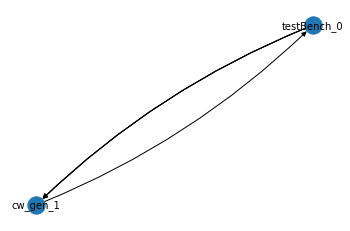

In [7]:
graph.draw(seed=1)

### Let's run it

An finally let's run this graph and see the result continious wave:

Applied NCO reset.
Generating CW at 10000000.000000 Hz ...
Captured 100 samples.
Generation completed. NCO stopped.


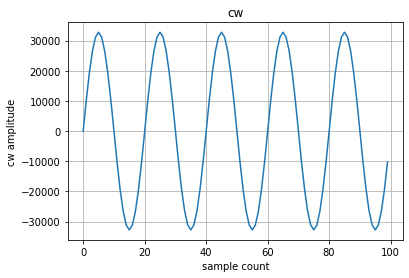

In [8]:
rt = DeltaPySimulator(graph)
rt.run()

### Conclusions

The main point of this example is to show how to simulate realistic hardware,
and how to test such a node in isolation from other nodes.